# Tranfer Learnning to Flower Recognition using PyTorch 🔥
This dataset contains labeled 4242 images of flowers.


### Content
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Data
You can download data from: [Flowers Recognition Dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

In [1]:
import numpy as np
import pandas as pd
import os
path="./"
os.listdir(path)

['.config', 'archive.zip', 'sample_data']

In [2]:
!unzip archive.zip

Archive:  archive.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: fl

In [3]:
path="./flowers"
os.listdir(path)

['dandelion', 'tulip', 'daisy', 'rose', 'sunflower']

In [4]:
classes=['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

In [ ]:
print(len(classes))

5


In [5]:
label_of_file=[]
img_list=[]

for kind in classes:
    kind_parh=os.path.join(path,kind)

    for img in os.listdir(kind_parh):
        img_list.append(os.path.join(kind_parh,img))
        label_of_file.append(kind)

df=pd.DataFrame({'img':img_list,'label':label_of_file})
df.head(3)
df = df.sample(frac=1).reset_index(drop=True)
df.head(2)

,img,label
0,./flowers/dandelion/6103898045_e066cdeedf_n.jpg,dandelion
1,./flowers/tulip/391477275_7c2f50a1a7_m.jpg,tulip


In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['encode_label'] = encoder.fit_transform(df['label'])
df['encode_label'] = df['encode_label'].astype('int64') #convertir a long dado que el entreamiento falla si esto no se realiza #20240901

In [ ]:
df.head(10)

,img,label,encode_label
0,./flowers/tulip/8572847041_d0cc07861f_n.jpg,tulip,4
1,./flowers/dandelion/2443192475_c64c66d9c2.jpg,dandelion,1
2,./flowers/tulip/14069841138_e2b403f44f_n.jpg,tulip,4
3,./flowers/daisy/18354545086_693ea7bc2a.jpg,daisy,0
4,./flowers/daisy/33838292353_8b143f7980_n.jpg,daisy,0
5,./flowers/dandelion/2387025546_6aecb1b984_n.jpg,dandelion,1
6,./flowers/tulip/5433747333_869a2a172d_m.jpg,tulip,4
7,./flowers/daisy/14921511479_7b0a647795.jpg,daisy,0
8,./flowers/dandelion/14404468648_37903d7025_m.jpg,dandelion,1
9,./flowers/rose/15094168139_8f636ffa1d_n.jpg,rose,2


In [24]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import random
random.seed(42)


In [ ]:
example_img = cv2.imread(df['img'][2])
example_img.shape

(159, 240, 3)

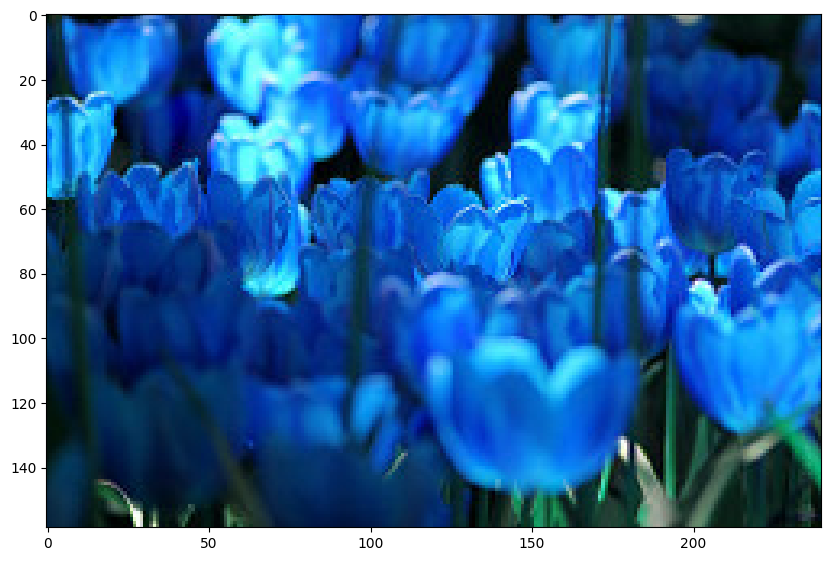

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(example_img)
plt.show()

In [8]:
# este codigo debe ser modificado -- 20240831

#import numpy as np
#x=[]
#for img in df['img']:
#    try:
#        img = cv2.imread(img)
#        img = cv2.resize(img, (150, 150))
#        img = img / 255.0  # normalize
#        x.append(img)      # img

#    except:
#        print(f"Error loading image: {img}")

# resnet 50 solo soporta imagenes de 224x224 y con la normalizacion esperada
import numpy as np
x = []
for img in df['img']:
    try:
        img = cv2.imread(img)
        img = cv2.resize(img, (224, 224))  # Cambiar tamaño a 224x224

        # Convertir de BGR a RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalizar
        img = img / 255.0

        # Aplicar la normalización esperada por ResNet-50
        #img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

        # Convertir a tensor y cambiar el orden a (C, H, W)
        #img = np.transpose(img, (2, 0, 1))
        #img = torch.tensor(img, dtype=torch.float32)

        x.append(img)

    except Exception as e:
        print(f"Error loading image: {img}, Error: {e}")


In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(device)

cuda


## Modeling

In [10]:
# Elimina todos los objetos en CUDA
torch.cuda.empty_cache()

In [11]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(x, df['encode_label'], test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Datos sin data augmentation


In [12]:
from torch.utils.data import DataLoader, TensorDataset

# Convertir cada conjunto de datos en tensores
x_train_tensors = [torch.tensor(img, dtype=torch.float32) for img in X_train]
x_val_tensors = [torch.tensor(img, dtype=torch.float32) for img in X_val]
x_test_tensors = [torch.tensor(img, dtype=torch.float32) for img in X_test]

X_train_tensor = torch.stack(x_train_tensors)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.stack(x_val_tensors)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

X_test_tensor = torch.stack(x_test_tensors)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Crear TensorDataset para cada conjunto
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Crear DataLoader para iterar sobre los datasets en lotes
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Datos con data augmentation

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Definir las transformaciones de data augmentation
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])

# Convertir cada conjunto de datos en tensores y aplicar permutación para asegurarse del formato correcto
x_train_tensors = [torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) for img in X_train]  # De [H, W, C] a [C, H, W]
x_val_tensors = [torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) for img in X_val]
x_test_tensors = [torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) for img in X_test]

X_train_tensor = torch.stack(x_train_tensors)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.stack(x_val_tensors)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

X_test_tensor = torch.stack(x_test_tensors)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Crear TensorDataset para cada conjunto
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Aplicar data augmentation solo en el DataLoader de entrenamiento
def train_collate_fn(batch):
    augmented_images = []
    labels = []
    for img, label in batch:
        img = data_augmentation(img)  # Aplicar data augmentation
        augmented_images.append(img)
        labels.append(label)
    return torch.stack(augmented_images), torch.tensor(labels)

# Crear DataLoader para iterar sobre los datasets en lotes
batch_size = 32

# DataLoader de entrenamiento con data augmentation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_collate_fn)

# DataLoader de validación y prueba sin data augmentation
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:


# Cargar el modelo ResNet-50 preentrenado
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Reemplazar la última capa (fc) con un bloque similar al que usaste en TensorFlow
#model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#num_ftrs = model.fc.in_features
#model.fc = nn.Sequential(
#    nn.Linear(num_ftrs, 5),        # Capa totalmente conectada con 5 salidas
#    nn.Softmax(dim=1)              # Softmax para obtener probabilidades
#)

model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
num_ftrs = model.fc.in_features

# Bloque de capas personalizadas similar a lo que tienes en Keras
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2048),       # Capa totalmente conectada con 2048 neuronas (primera capa densa)
    nn.ReLU(),                       # Activación ReLU
    nn.Dropout(0.2),                 # Dropout para evitar sobreajuste
    nn.Linear(2048, 1024),           # Capa totalmente conectada con 1024 neuronas (segunda capa densa)
    nn.ReLU(),                       # Activación ReLU
    nn.Dropout(0.2),                 # Dropout adicional
    nn.Linear(1024, 5),              # Capa de salida con 5 neuronas (correspondiente a 5 clases)
    nn.Softmax(dim=1)                # Softmax para obtener probabilidades
)

# Congelar todas las capas excepto las últimas
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


In [19]:
criterion = torch.nn.CrossEntropyLoss()
# Reajustar el optimizador con un learning rate más bajo para el fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)


In [20]:
def train_model(model, criterion, optimizer, train_loader,val_loader, num_epochs=3, device=device):
    model.to(device)  # Mover el modelo al dispositivo adecuado (CPU o GPU)
    model.train()  # Poner el modelo en modo de entrenamiento

    for epoch in range(num_epochs):
        running_loss = 0.0  # Acumulador para la pérdida

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover los datos al dispositivo
            #print(f"Shape of inputs: {inputs.shape}") #solo necesario para validar las dimensiones del tensor comentado para evitar impresion
            optimizer.zero_grad()  # Resetear los gradientes

            # Asegurarse de que los datos están en el formato correcto
            if inputs.ndim == 4 and inputs.shape[1] != 3:
                inputs = inputs.permute(0, 3, 1, 2)

            inputs = inputs.float()  # Asegurarse de que las entradas son de tipo float32

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item() * inputs.size(0)  # Acumular la pérdida multiplicada por el tamaño del lote
            #print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss/len(X_train)}")
        # Calcular la pérdida promedio por época
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")
   # Validación (si se proporciona un val_loader)
        if val_loader:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    # que el tensor esté en el formato [batch_size, 3, height, width]
                    if val_inputs.ndim == 4 and val_inputs.shape[1] != 3:
                        val_inputs = val_inputs.permute(0, 3, 1, 2)  # Cambiar a [batch_size, 3, height, width]

                    val_outputs = model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item() * val_inputs.size(0)

                    _, predicted = torch.max(val_outputs, 1)
                    correct += (predicted == val_labels).sum().item()
                    total += val_labels.size(0)

            val_loss /= len(val_loader.dataset)
            accuracy = correct / total
            print(f"Epoch {epoch+1}/{num_epochs} Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
            model.train()  # Volver al modo de entrenamiento después de la validación



In [25]:
train_model(model=model, criterion=criterion, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, num_epochs=30, device=device)

Epoch 1/30 Loss: 0.9575
Epoch 1/30 Validation Loss: 1.0082, Accuracy: 0.9074
Epoch 2/30 Loss: 0.9565
Epoch 2/30 Validation Loss: 1.0086, Accuracy: 0.9108
Epoch 3/30 Loss: 0.9561
Epoch 3/30 Validation Loss: 1.0037, Accuracy: 0.9160
Epoch 4/30 Loss: 0.9525
Epoch 4/30 Validation Loss: 1.0052, Accuracy: 0.9142
Epoch 5/30 Loss: 0.9503
Epoch 5/30 Validation Loss: 1.0038, Accuracy: 0.9057
Epoch 6/30 Loss: 0.9505
Epoch 6/30 Validation Loss: 1.0042, Accuracy: 0.9125
Epoch 7/30 Loss: 0.9514
Epoch 7/30 Validation Loss: 1.0034, Accuracy: 0.9074
Epoch 8/30 Loss: 0.9483
Epoch 8/30 Validation Loss: 1.0027, Accuracy: 0.9108
Epoch 9/30 Loss: 0.9481
Epoch 9/30 Validation Loss: 1.0062, Accuracy: 0.9125
Epoch 10/30 Loss: 0.9461
Epoch 10/30 Validation Loss: 1.0011, Accuracy: 0.9177
Epoch 11/30 Loss: 0.9458
Epoch 11/30 Validation Loss: 0.9999, Accuracy: 0.9091
Epoch 12/30 Loss: 0.9459
Epoch 12/30 Validation Loss: 1.0032, Accuracy: 0.9108
Epoch 13/30 Loss: 0.9421
Epoch 13/30 Validation Loss: 0.9992, Accuracy

In [26]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if inputs.ndim == 4 and inputs.shape[1] != 3:
                inputs = inputs.permute(0, 3, 1, 2)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.4f}%)')

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device='cuda')


Test Accuracy: 0.9282
Test set: Average loss: 422.9574, Accuracy: 401/432 (0.9282%)


# Experimentos (todo comentado no es necesario correr)

```
Resultado data augmentation

Train
Epoch 1/3 Loss: 1.4285
Epoch 1/3 Validation Loss: 1.2503, Accuracy: 0.8027
Epoch 2/3 Loss: 1.2274
Epoch 2/3 Validation Loss: 1.1487, Accuracy: 0.8370
Epoch 3/3 Loss: 1.1646
Epoch 3/3 Validation Loss: 1.1108, Accuracy: 0.8611
Test
Test Accuracy: 0.8519
Test set: Average loss: 486.4041, Accuracy: 368/432 (0.8519%)


Resultado sin data augmentation

Train
Epoch 1/3 Loss: 1.1065
Epoch 1/3 Validation Loss: 1.0799, Accuracy: 0.8919
Epoch 2/3 Loss: 1.0809
Epoch 2/3 Validation Loss: 1.0602, Accuracy: 0.8919
Epoch 3/3 Loss: 1.0635
Epoch 3/3 Validation Loss: 1.0521, Accuracy: 0.8902
Test
Test Accuracy: 0.8935
Test set: Average loss: 459.1141, Accuracy: 386/432 (0.8935%)


In [ ]:
#from torch.utils.data import DataLoader, TensorDataset


# Convertir cada imagen de numpy array a tensor
#x_tensors = [torch.tensor(img, dtype=torch.float32) for img in x]

# Combinar la lista de tensores en un solo tensor
#X_train = torch.stack(x_tensors)
#y_train = torch.tensor(df['encode_label'].values, dtype=torch.long)  # Asegúrate de que las etiquetas son de tipo long


# Crear un TensorDataset combinando las imágenes y las etiquetas
#train_dataset = TensorDataset(X_train, y_train)

# Crear un DataLoader para iterar sobre el dataset en lotes
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# using dataloader
#X_train = DataLoader(x, batch_size=32, shuffle=True)
#y_train = DataLoader(df['encode_label'], batch_size=32, shuffle=True)

#for X_train, y_train in zip(X_train, y_train):
    #print(f"Shape of X [N, C, H, W]: {X_train.shape}")
    #print(f"Transformed X [N, C, H, W]:{X_train.permute(0, 3, 1, 2).shape}")
    #print(f"Shape of y: {y_train.shape} {y_train.dtype}")
    #break

#X_train.to(device)
#y_train.to(device)

Shape of X [N, C, H, W]: torch.Size([32, 224, 224, 3])
Shape of y: torch.Size([32]) torch.int64


In [ ]:
#model = models.resnet50(pretrained=True)

#model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#num_ftrs = model.fc.in_features
#model.fc = nn.Sequential(
#    nn.Linear(num_ftrs, 5),
#    nn.Softmax(dim=1)
#)


In [ ]:
# train Model
#criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [ ]:
# train model
#def train_model(model, criterion, optimizer, num_epochs=3 ,device=device):
#  model.to(device)
#  model.train()
  # Cast the model weights to double precision (float64)
#  model = model.double()
#  for epoch in range(num_epochs):
#    running_loss = 0.0
#    for inputs, labels in zip(X_train, y_train):
      #inputs = inputs.to(device)
      #labels = labels.to(device)
#      optimizer.zero_grad()
#      print(f"Shape of inputs: {inputs.shape}")
      # Permute the dimensions of the input tensor
#      inputs = inputs.permute(0, 3, 1, 2) # Change the order of dimensions from [batch_size, height, width, channels] to [batch_size, channels, height, width]
      # Cast the inputs to double precision (float64)
#      inputs = inputs.double()
#      outputs = model(inputs)
#      loss = criterion(outputs, labels)
#      loss.backward()
#      optimizer.step()
#      running_loss += loss.item() * inputs.size(0)
#      print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss/len(X_train)}")

#def train_model(model, criterion, optimizer, train_loader, num_epochs=3, device=device):
#    model.to(device)  # Mover el modelo al dispositivo adecuado (CPU o GPU)
#    model.train()  # Poner el modelo en modo de entrenamiento

#    for epoch in range(num_epochs):
#        running_loss = 0.0  # Acumulador para la pérdida

#        for inputs, labels in train_loader:
#            inputs, labels = inputs.to(device), labels.to(device)  # Mover los datos al dispositivo
#            print(f"Shape of inputs: {inputs.shape}")
#            optimizer.zero_grad()  # Resetear los gradientes

            # Asegurarse de que los datos están en el formato correcto
#           if inputs.ndim == 4 and inputs.shape[1] != 3:
#                inputs = inputs.permute(0, 3, 1, 2)

#          inputs = inputs.float()  # Asegurarse de que las entradas son de tipo float32

#            outputs = model(inputs)  # Forward pass
#            loss = criterion(outputs, labels)  # Calcular la pérdida
#            loss.backward()  # Backpropagation
#            optimizer.step()  # Actualizar los pesos

 #           running_loss += loss.item() * inputs.size(0)  # Acumular la pérdida multiplicada por el tamaño del lote
 #           print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss/len(X_train)}")
        # Calcular la pérdida promedio por época
 #       epoch_loss = running_loss / len(train_loader.dataset)
 #       print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")


In [ ]:
#def train_model(model, criterion, optimizer, train_loader, num_epochs=3, device=device):
 #   model.to(device)  # Mover el modelo al dispositivo adecuado (CPU o GPU)
  #  model.train()  # Poner el modelo en modo de entrenamiento

   # for epoch in range(num_epochs):
    #    running_loss = 0.0  # Acumulador para la pérdida

     #   for inputs, labels in train_loader:
      #      inputs, labels = inputs.to(device), labels.to(device)  # Mover los datos al dispositivo
       #     print(f"Shape of inputs: {inputs.shape}")
        #    optimizer.zero_grad()  # Resetear los gradientes

            # Asegurarse de que los datos están en el formato correcto
         #   if inputs.ndim == 4 and inputs.shape[1] != 3:
          #      inputs = inputs.permute(0, 3, 1, 2)

           # inputs = inputs.float()  # Asegurarse de que las entradas son de tipo float32

            #outputs = model(inputs)  # Forward pass
            #loss = criterion(outputs, labels)  # Calcular la pérdida
            #loss.backward()  # Backpropagation
            #optimizer.step()  # Actualizar los pesos

            #running_loss += loss.item() * inputs.size(0)  # Acumular la pérdida multiplicada por el tamaño del lote
            #print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss/len(X_train)}")
        # Calcular la pérdida promedio por época
        #epoch_loss = running_loss / len(train_loader.dataset)
        #print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

In [ ]:
# Test Model
#def test_model(model):
#  model.eval()
#  test_loss = 0.0
#  correct = 0
#  with torch.no_grad():
#    for inputs, labels in zip(X_train, y_train):
      # Permute the dimensions of the input tensor
#      inputs = inputs.permute(0, 3, 1, 2) # Change the order of dimensions from [batch_size, height, width, channels] to [batch_size, channels, height, width]
#      outputs = model(inputs)
#      test_loss += criterion(outputs, labels).item() * inputs.size(0)
#      pred = outputs.argmax(dim=1, keepdim=True)
#      correct += pred.eq(labels.view_as(pred)).sum().item()
#  test_loss /= len(X_train.dataset)
#  test_accuracy = 100. * correct / len(X_train.dataset)
#  print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(X_train.dataset)} ({test_accuracy:.0f}%)')

In [ ]:
# training
#train_model(model, criterion, optimizer, train_loader,num_epochs=3, device=device)